In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# install graph-tool
!wget https://downloads.skewed.de/skewed-keyring/skewed-keyring_1.0_all_$(lsb_release -s -c).deb
!dpkg -i skewed-keyring_1.0_all_$(lsb_release -s -c).deb
!echo "deb [signed-by=/usr/share/keyrings/skewed-keyring.gpg] https://downloads.skewed.de/apt $(lsb_release -s -c) main" > /etc/apt/sources.list.d/skewed.list
!apt-get update
!apt-get install python3-graph-tool python3-matplotlib python3-cairo

--2024-11-07 19:21:22--  https://downloads.skewed.de/skewed-keyring/skewed-keyring_1.0_all_jammy.deb
Resolving downloads.skewed.de (downloads.skewed.de)... 49.12.93.194
Connecting to downloads.skewed.de (downloads.skewed.de)|49.12.93.194|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23192 (23K) [application/x-debian-package]
Saving to: ‘skewed-keyring_1.0_all_jammy.deb’

skewed-keyring_1.0_ 100%[===================>]  22.65K   109KB/s    in 0.2s    

2024-11-07 19:21:24 (109 KB/s) - ‘skewed-keyring_1.0_all_jammy.deb’ saved [23192/23192]

Selecting previously unselected package skewed-keyring.
(Reading database ... 123623 files and directories currently installed.)
Preparing to unpack skewed-keyring_1.0_all_jammy.deb ...
Unpacking skewed-keyring (1.0) ...
Setting up skewed-keyring (1.0) ...
Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Get:2 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:3 https:

In [3]:
# Install dependencies
# Colab uses a Python install that deviates from the system's! Bad colab! We need some workarounds.
!apt purge python3-cairo
!apt install libcairo2-dev pkg-config python3-dev
!pip install --force-reinstall pycairo
!pip install zstandard

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following packages will be REMOVED:
  python3-cairo*
0 upgraded, 0 newly installed, 1 to remove and 52 not upgraded.
After this operation, 310 kB disk space will be freed.
(Reading database ... 132030 files and directories currently installed.)
Removing python3-cairo:amd64 (1.20.1-3build1) ...
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
python3-dev is already the newest version (3.10.6-1~22.04.1).
python3-dev set to manually installed.
The following packages were automatically installed and are no longer required:
  libbz2-dev libpkgconf3 libreadline-dev
Use 'apt autoremove' to remove them.
The following additional packages will be installed:
  libblkid-dev libblkid1 libcairo-script-interpreter2 libffi-dev libglib2.0-dev libglib2.0-dev-bin
  libice-dev liblzo2-2 libmount-dev libmount1 libpixman-1-dev libselinux1-dev libsepol-dev
  lib

In [1]:
!pip uninstall -y matplotlib
!pip install matplotlib==3.7.2 # installing an older version on Matplotlib

Found existing installation: matplotlib 3.7.2
Uninstalling matplotlib-3.7.2:
  Successfully uninstalled matplotlib-3.7.2
  Using cached matplotlib-3.7.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (5.6 kB)
Using cached matplotlib-3.7.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (11.6 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
plotnine 0.14.0 requires matplotlib>=3.8.0, but you have matplotlib 3.7.2 which is incompatible.


In [1]:
# import packages
import graph_tool.all as gt
import csv
import pickle
import numpy as np
import pandas
import math
import random
import scipy.optimize
import scipy.interpolate
import scipy.io
import h5py
import sklearn
import sklearn.metrics
import copy
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.colors import ListedColormap
# import matplotlib.gridspec as gridspec
from matplotlib import patches
from matplotlib.patches import Rectangle
from mpl_toolkits.axes_grid1.inset_locator import InsetPosition
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits import mplot3d
%matplotlib inline

In [4]:
# load Connectome
class MidpointNormalize(colors.Normalize):
    def __init__(self,vmin=None,vmax=None,midpoint=None,clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self,vmin,vmax,clip)

    def __call__(self,value,clip=None):
        x,y = [self.vmin, self.midpoint, self.vmax], [0,0.5,1]
        return np.ma.masked_array(np.interp(value,x,y))

def sorted_eigs(X):
    n = np.shape(X)[0]
    y,v = np.linalg.eig(X)
    vtmp = copy.deepcopy(y)
    for i in range(n):
        for j in range(i+1,n):
            if y[j] > y[i]:
                tmp = y[i]
                y[i] = y[j]
                y[j] = tmp
                vtmp[:] = v[:,i]
                v[:,i] = v[:,j]
                v[:,j] = vtmp[:]
    return y,v

def generate_blockIds(idpos,blocks):
    N = len(idpos)
    blockIds = -np.ones(N)
    for i in range(N):
        for j in range(len(blocks)):
            if idpos[i] in blocks[j]:
                blockIds[i] = j
    return blockIds

def final_adjustments(W,cdf):
    # make DOs negative
    W[:,cdf.loc['vest']] = -W[:,cdf.loc['vest']]
    W[:,cdf.loc['MO']] = -W[:,cdf.loc['MO']]

    # set ABD,vSPNs outgoing to 0
    W[:,cdf.loc['abdm']] = 0
    W[:,cdf.loc['abdi']] = 0
    W[:,cdf.loc['vspns']] = 0

    # set IBN outgoing to 0
    W[:,cdf.loc['Ibni']] = 0
    W[:,cdf.loc['Ibnm']] = 0

    # make Axial modules 0
    W[:,cdf.loc['axl']] = 0
    W[cdf.loc['axl'],:] = 0

    W[:,cdf.loc['axlm']] = 0
    W[cdf.loc['axlm'],:] = 0
    return W

def get_scaled_slopes(W,cdf,sf=-1):
    y,v = sorted_eigs(W) # call funciton
    slopes = np.real(v[:,0])
    if sf < 0:
        sf = 2.574 / np.mean(slopes[cdf.loc['integ']])
    return sf*slopes


#connMatFile = 'data/ConnMatrixPre_cleaned.mat'
connMatFile = '/content/drive/MyDrive/Colab Notebooks/Sood_code/data/ConnMatrix_CO_top500_2blocks_gamma038_08062020.mat'
connMat = scipy.io.loadmat(connMatFile)
connMatDict = list(connMat)
connMat = np.float32(connMat[connMatDict[-1]])
N = np.shape(connMat)[0]
print(N)

totalInputFile = '/content/drive/MyDrive/Colab Notebooks/Sood_code/data/totalInputs_CO_top500_2blocks_gamma038_08062020.mat'
totalInputs = scipy.io.loadmat(totalInputFile)
totalInputsDict = list(totalInputs)
totalInputs = np.int32(totalInputs[totalInputsDict[-1]])
totalInputs = np.ravel(totalInputs)

# load cellIDs
cellIDFile  = '/content/drive/MyDrive/Colab Notebooks/Sood_code/data/cellIDType_CO_top500_2blocks_gamma038_08062020.mat'
cellIDs = scipy.io.loadmat(cellIDFile)
cellIDFileDict = list(cellIDs)
cellIDs = cellIDs[cellIDFileDict[-1]]
cellIDs_unique = set(cellIDs)

matOrderFile  =  '/content/drive/MyDrive/Colab Notebooks/Sood_code/data/MatOrder_CO_top500_2blocks_gamma038_08062020.mat'
matOrder = scipy.io.loadmat(matOrderFile)
idpos = matOrder['MatOrder_CO_top500_2blocks_gamma038_08062020'][0]

louvain_blocks = []
blockFile = '/content/drive/MyDrive/Colab Notebooks/Sood_code/data/block1_cleaned_gamma038_08072020.mat'
block1 = scipy.io.loadmat(blockFile)
louvain_blocks.append(block1['block1_cleaned'][0][0][0][0])
blockFile = '/content/drive/MyDrive/Colab Notebooks/Sood_code/data/block2_cleaned_gamma038_08072020.mat'
block2 = scipy.io.loadmat(blockFile)
louvain_blocks.append(block2['block2_cleaned'][0][0][0][0])

# # sbm_blocks = []
# # blockFile = '../tmp/SBM_celltype_eig.mat'
# # block_assignments = scipy.io.loadmat(blockFile)
# # block_assignments = block_assignments['SBM_celltype_eig']
# # idFile = '../tmp/SBM_cellid_eig.mat'
# # cell_ids = scipy.io.loadmat(idFile)
# # cell_ids = cell_ids['SBM_cellid_eig'][0]
# # sbm_blocks.append(cell_ids[block_assignments == 'AM   '])
# # sbm_blocks.append(cell_ids[block_assignments == 'OM   '])

lbid = generate_blockIds(idpos,louvain_blocks)
# sbmid = generate_blockIds(idpos,sbm_blocks)


connMatFile = '/content/drive/MyDrive/Colab Notebooks/Sood_code/data/ConnMatrixPre_cleaned.mat'
connMatBig = scipy.io.loadmat(connMatFile)
connMatDict = list(connMatBig)
connMatBig = np.float32(connMatBig[connMatDict[-1]])
cellFile = '/content/drive/MyDrive/Colab Notebooks/Sood_code/data/AllCells.mat'
cells = scipy.io.loadmat(cellFile)
cell_locs = np.zeros(N,dtype=np.int32)
for i in range(N):
    cell_locs[i] = np.where(cells['AllCells'][:,0] == idpos[i])[0]
y,v = np.linalg.eig(connMatBig)
vR = v[:,np.argmax(np.real(y))]
y,v = np.linalg.eig(np.transpose(connMatBig))
vL = v[:,np.argmax(np.real(y))]
centrality = abs(vL*vR)
centrality = centrality[cell_locs]
threshold = np.percentile(centrality[lbid >= 0],25)
flag = (centrality <= threshold) & (lbid >= 0)
#keep = (centrality > threshold) | (lbid < 0)
#connMat = connMat[np.ix_(keep,keep)]
#N = np.shape(connMat)[0]
#print(N)
#totalInputs = totalInputs[keep]
#cellIDs = cellIDs[keep]
#idpos = idpos[keep]
#lbid = lbid[keep]
#sbmid = sbmid[keep]


# redo connectome with potential synapses
#connMatFile = 'data/potentialSynapses_2.mat'
#connMat = scipy.io.loadmat(connMatFile)
#connMatDict = list(connMat)
#connMat = np.float32(connMat[connMatDict[-1]])
#cellFile = 'data/AllCells.mat'
#cells = scipy.io.loadmat(cellFile)
#cell_locs = np.zeros(N,dtype=np.int32)
#for i in range(N):
#    cell_locs[i] = np.where(cells['AllCells'][:,0] == idpos[i])[0]
#totalInputs = np.sum(connMat[cell_locs,:],axis=1)
#connMat = connMat[np.ix_(cell_locs,cell_locs)]
#print(np.shape(connMat))
#f = open('data/potentialSynapses_louvainBlockAssignments.data','rb')
#blockDict = pickle.load(f)
#f.close()
#lbid = blockDict['Potential Synapses 2um']

# get location of neurons
cellLocations =  np.array([(cellIDs == '_Int_'),(cellIDs == 'Ibn_m'),(cellIDs == 'Ibn_i'),(cellIDs == '_MOs_'),(cellIDs == '_Axlm'), (cellIDs == '_Axl_'), (cellIDs == '_DOs_'),(cellIDs == 'ABD_m'),(cellIDs == 'ABD_i'), (cellIDs == 'vSPNs')])
cellNames = ('integ','Ibnm','Ibni','MO','axlm','axl','vest','abdm','abdi','vspns')
lb_cdf = pandas.DataFrame(cellLocations,cellNames)
lb_A = copy.deepcopy(connMat)

# cellLocations =  np.array([(sbmid == 1) & (cellIDs != '_DOs_'),(cellIDs == 'Ibn_m'),(cellIDs == 'Ibn_i'),(cellIDs == '_MOs_'),(cellIDs == '_Axlm'), (sbmid == 0), (cellIDs == '_DOs_'),(cellIDs == 'ABD_m'),(cellIDs == 'ABD_i'), (cellIDs == 'vSPNs')])
# sbm_cdf = pandas.DataFrame(cellLocations,cellNames)
# #sbm_A = copy.deepcopy(connMat)

# connMat[:,sbm_cdf.loc['abdm']] = 0
# connMat[:,sbm_cdf.loc['abdi']] = 0

# normalize W matrix by total inputs
lb_Wnorm = np.zeros(connMat.shape)
sbm_Wnorm = np.zeros(connMat.shape)
for i in np.arange(connMat.shape[0]):
    if totalInputs[i]>0:
        lb_Wnorm[i,:] = connMat[i,:] / totalInputs[i,None]
        sbm_Wnorm[i,:] = connMat[i,:] / totalInputs[i,None]

# Weight matrix including modA connections
lb_Wall = copy.deepcopy(lb_Wnorm)
sbm_Wall = copy.deepcopy(sbm_Wnorm)
lb_Wall[:,lb_cdf.loc['vest']] = -lb_Wall[:,lb_cdf.loc['vest']]
lb_Wall[:,lb_cdf.loc['abdm']] = 0
lb_Wall[:,lb_cdf.loc['abdi']] = 0
lb_Wall[:,lb_cdf.loc['vspns']] = 0
# sbm_Wall[:,sbm_cdf.loc['vest']] = -sbm_Wall[:,sbm_cdf.loc['vest']]
# sbm_Wall[:,sbm_cdf.loc['abdm']] = 0
# sbm_Wall[:,sbm_cdf.loc['abdi']] = 0
# sbm_Wall[:,sbm_cdf.loc['vspns']] = 0
# Weight matrix without modA connections
lb_Wnorm = final_adjustments(lb_Wnorm,lb_cdf)
# sbm_Wnorm = final_adjustments(sbm_Wnorm,sbm_cdf)
lb_slopes = get_scaled_slopes(lb_Wnorm,lb_cdf)
# sbm_slopes = get_scaled_slopes(sbm_Wnorm,sbm_cdf)
# Weight matrix without input normalization
# sbm_Wraw = final_adjustments(copy.deepcopy(connMat),sbm_cdf)
# sbm_slopes_raw = get_scaled_slopes(sbm_Wraw,sbm_cdf)
# #Adjacency matrix
# sbm_A = copy.deepcopy(connMat)
# sbm_A[:,sbm_cdf.loc['abdm']] = 0
# sbm_A[:,sbm_cdf.loc['abdi']] = 0
# sbm_A[:,sbm_cdf.loc['vspns']] = 0
# sbm_A[:,sbm_cdf.loc['axl']] = 0
# sbm_A[sbm_cdf.loc['axl'],:] = 0

609


<ipython-input-4-5420550ebdb2>:120: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  cell_locs[i] = np.where(cells['AllCells'][:,0] == idpos[i])[0]


In [5]:
# Get kvalues from simulation
def simulate_ks(W_in,ymax,ynew=0.99,tau=0.1,v_in=[]):
    W = copy.deepcopy(W_in)
    W = ynew*W/ymax
    N = np.shape(W)[0]
    #y,v = sorted_eigs(W)
    #if np.sum(np.real(v[:,0])) < 0:
    #    v[:,0] = -v[:,0]
    #if np.sum(np.real(v[:,0])) > 0:
    #    v[:,1] = -v[:,1]
    #v_in = v[:,0] + v[:,1]
    if np.shape(v_in)[0] < N:
        v_in = abs(np.random.randn(N))
        v_in = v_in / np.linalg.norm(v_in)
    input_filter = 0.001*np.exp(-np.linspace(0,10,101))
    I = np.zeros(7000)
    I[995:1005] = 1e5
    I = np.convolve(I,input_filter)[0:7000]
    r = np.zeros((7000,N))
    dt = 0.001
    positions = np.ones((36,2))
    positions[12:24,0] = 2
    positions[24:,0] = 3
    responses = np.ones((36,N))
    for k in range(3):
        r[0,:] = r[-1,:]
        for i in range(1,7000):
            r[i,:] = r[i-1,:] + dt*(np.dot(W,r[i-1,:]) - r[i-1,:] + I[i-1]*v_in)/tau
            #r = r * (r > 0)
        responses[k*12:(k+1)*12,:] = r[3333::333,:]
    ks = np.zeros(N)
    for i in range(N):
        res = scipy.optimize.lsq_linear(positions,responses[:,i],bounds=([0,-np.inf],[np.inf,np.inf]))
        ks[i] = res.x[0]
    return ks

# Plotting Functions

In [57]:
def compare_khist(slopes,cdfs,labels,fill=True,lw=0.5,spacing=1.0,gap=0):
    ax = plt.gca()
    for i in range(0,5):
        plt.axhline(i,linestyle='--',color='gray',alpha=0.5,linewidth=1)
    plt.axhline(5,linestyle='-',color='gray',alpha=0.5,linewidth=1)
    for i in range(6,10):
        plt.axhline(i,linestyle='--',color='gray',alpha=0.5,linewidth=1)
    plt.axhline(10,linestyle='-',color='gray',alpha=0.5,linewidth=1)
    for i in range(11,15):
        plt.axhline(i,linestyle='--',color='gray',alpha=0.5,linewidth=1)
    xcent = [1*spacing,3*spacing,5*spacing]
    bins = np.linspace(-1.5,100.5,103)
    bw = bins[1]-bins[0]
    ec1 = 'black'
    ec2 = 'green'
    ax.add_patch(Rectangle(((xcent[0]+xcent[1])/2,14.25),0.1,bw,facecolor='gray',edgecolor=ec1,linewidth=lw))
    plt.text((xcent[0]+xcent[1])/2+0.15,14.25,labels[0],fontsize=12)
    ax.add_patch(Rectangle(((xcent[1]+xcent[2])/2,14.25),0.1,bw,facecolor='mediumaquamarine',edgecolor=ec2,linewidth=lw))
    plt.text((xcent[1]+xcent[2])/2+0.15,14.25,labels[1],fontsize=12)
    nint = np.sum(cdfs[0].loc['integ'])
    ntrials = np.shape(slopes[0])[1]
    int_slopes = np.reshape(slopes[0][cdfs[0].loc['integ'],:],(nint*ntrials,))
    threshold1 = np.percentile(int_slopes,1)
    threshold2 = np.percentile(int_slopes,99)
    int_slopes[int_slopes <= threshold1] = -99
    int_slopes[int_slopes >= threshold2] = -99
    model_counts = [nint] # AV
    hist,be = np.histogram(int_slopes,bins=bins)#,density=True)
    #for i in range(1,np.shape(slopes[0])[1]):
    #    hist2,be = np.histogram(slopes[0][:,i][cdfs[0].loc['integ']],bins=bins)#,density=True)
    #    hist += hist2
    hist = hist / (nint*ntrials - np.sum(int_slopes <= threshold1))
    for i in range(1,17):
        if hist[i] > 0.001:
            ax.add_patch(Rectangle((xcent[0]-gap-hist[i],bins[i]),hist[i],bw,facecolor='gray',edgecolor=ec1,linewidth=lw))

    nint = np.sum(cdfs[1].loc['integ'])
    ntrials = np.shape(slopes[1])[1]
    int_slopes = np.reshape(slopes[1][cdfs[1].loc['integ'],:],(nint*ntrials,))
    threshold1 = np.percentile(int_slopes,1)
    threshold2 = np.percentile(int_slopes,99)
    int_slopes[int_slopes <= threshold1] = -99
    int_slopes[int_slopes >= threshold2] = -99
    hist,be = np.histogram(int_slopes,bins=bins)
    #threshold = np.percentile(np.max(slopes[1][cdfs[1].loc['integ'],:]),95)
    #hist,be = np.histogram(slopes[1][:,0][cdfs[1].loc['integ']],bins=bins)#,density=True)
    #for i in range(1,np.shape(slopes[1])[1]):
    #    hist2,be = np.histogram(slopes[1][:,i][cdfs[1].loc['integ']],bins=bins)#,density=True)
    #    hist += hist2
    hist = hist / (nint*ntrials - np.sum(int_slopes <= threshold1))
    functional_counts = [int_slopes.shape[0]] # AV
    for i in range(1,17):
        if hist[i] > 0.001:
            ax.add_patch(Rectangle((xcent[0]+gap,bins[i]),hist[i],bw,facecolor='mediumaquamarine',edgecolor=ec2,linewidth=lw))

    nvest = np.sum(cdfs[0].loc['vest'])
    ntrials = np.shape(slopes[0])[1]
    vest_slopes = np.reshape(slopes[0][cdfs[0].loc['vest'],:],(nvest*ntrials,))
    threshold1 = np.percentile(vest_slopes,1)
    threshold2 = np.percentile(vest_slopes,99)
    vest_slopes[vest_slopes <= threshold1] = -99
    vest_slopes[vest_slopes >= threshold2] = -99
    model_counts.append(nvest)
    hist,be = np.histogram(vest_slopes,bins=bins)
    #hist,be = np.histogram(slopes[0][:,0][cdfs[0].loc['vest']],bins=bins)#,density=True)
    #for i in range(1,np.shape(slopes[0])[1]):
    #    hist2,be = np.histogram(slopes[0][:,i][cdfs[0].loc['vest']],bins=bins)#,density=True)
    #    hist += hist2
    hist = hist / (nvest*ntrials - np.sum(vest_slopes <= threshold1))
    for i in range(1,17):
        if hist[i] > 0.001:
            ax.add_patch(Rectangle((xcent[1]-gap-hist[i],bins[i]),hist[i],bw,facecolor='gray',edgecolor=ec1,linewidth=lw))
    nvest = np.sum(cdfs[1].loc['vest'])
    ntrials = np.shape(slopes[1])[1]
    vest_slopes = np.reshape(slopes[1][cdfs[1].loc['vest'],:],(nvest*ntrials,))
    threshold1 = np.percentile(vest_slopes,1)
    threshold2 = np.percentile(vest_slopes,99)
    vest_slopes[vest_slopes <= threshold1] = -99
    vest_slopes[vest_slopes >= threshold2] = -99
    hist,be = np.histogram(vest_slopes,bins=bins)
    #hist,be = np.histogram(slopes[1][:,0][cdfs[1].loc['vest']],bins=bins)#,density=True)
    #for i in range(1,np.shape(slopes[1])[1]):
    #    hist2,be = np.histogram(slopes[1][:,i][cdfs[1].loc['vest']],bins=bins)#,density=True)
    #    hist += hist2
    print(np.sum(vest_slopes <= threshold1))
    hist = hist / (nvest*ntrials - np.sum(vest_slopes <= threshold1))
    functional_counts.append(vest_slopes.shape[0])
    for i in range(1,17):
        if hist[i] > 0.001:
            ax.add_patch(Rectangle((xcent[1]+gap,bins[i]),hist[i],bw,facecolor='mediumaquamarine',edgecolor=ec2,linewidth=lw))

    nabd = np.sum(cdfs[0].loc['abdm'] | cdfs[0].loc['abdi'])
    ntrials = np.shape(slopes[0])[1]
    abd_slopes = np.reshape(slopes[0][cdfs[0].loc['abdm'] | cdfs[0].loc['abdi'],:],(nabd*ntrials,))
    threshold1 = np.percentile(abd_slopes,1)
    threshold2 = np.percentile(abd_slopes,99)
    abd_slopes[abd_slopes <= threshold1] = -99
    abd_slopes[abd_slopes >= threshold2] = -99
    model_counts.append(nabd)
    hist,be = np.histogram(abd_slopes,bins=bins)
    #hist,be = np.histogram(slopes[0][:,0][cdfs[0].loc['abdm'] | cdfs[0].loc['abdi']],bins=bins)#,density=True)
    #for i in range(1,np.shape(slopes[0])[1]):
    #    hist2,be = np.histogram(slopes[0][:,i][cdfs[0].loc['abdm'] | cdfs[0].loc['abdi']],bins=bins)#,density=True)
    #    hist += hist2
    hist1 = hist / (nabd*ntrials - np.sum(abd_slopes <= threshold1))
    nabd = np.sum(cdfs[1].loc['abdm'] | cdfs[1].loc['abdi'])
    ntrials = np.shape(slopes[1])[1]
    abd_slopes = np.reshape(slopes[1][cdfs[1].loc['abdm'] | cdfs[1].loc['abdi'],:],(nabd*ntrials,))
    threshold1 = np.percentile(abd_slopes,1)
    threshold2 = np.percentile(abd_slopes,99)
    abd_slopes[abd_slopes <= threshold1] = -99
    abd_slopes[abd_slopes >= threshold2] = -99
    hist,be = np.histogram(abd_slopes,bins=bins)
    #threshold = np.percentile(np.max(slopes[1][cdfs[1].loc['abdm'] | cdfs[1].loc['abdi'],:],axis=0),95)
    #hist,be = np.histogram(slopes[1][:,0][cdfs[1].loc['abdm'] | cdfs[1].loc['abdi']],bins=bins)#,density=True)
    #for i in range(1,np.shape(slopes[1])[1]):
    #    #if np.max(slopes[1][cdfs[1].loc['abdm'] | cdfs[1].loc['abdi'],i]) > threshold:
    #    #    continue
    #    hist2,be = np.histogram(slopes[1][:,i][cdfs[1].loc['abdm'] | cdfs[1].loc['abdi']],bins=bins)#,density=True)
    #    hist += hist2
    hist2 = hist / (nabd*ntrials - np.sum(abd_slopes <= threshold1))
    functional_counts.append(abd_slopes.shape[0])
    for i in range(1,17):
        if hist1[i] > 0.001:
            ax.add_patch(Rectangle((xcent[2]-gap-hist1[i],bins[i]),hist1[i],bw,facecolor='gray',edgecolor=ec1,linewidth=lw))
    for i in range(1,17):
        if hist2[i] > 0.001:
            ax.add_patch(Rectangle((xcent[2]+gap,bins[i]),hist2[i],bw,facecolor='mediumaquamarine',edgecolor=ec2,linewidth=lw))
    plt.xticks(xcent,['VPNI','DO','ABD'])
    plt.xlim(xcent[0]-spacing,xcent[2]+spacing)
    plt.ylim(-0.5,15.5)
    plt.yticks([0,5,10,15])
    return model_counts,functional_counts

#plt.figure(1,(10,8))
#compare_khist([np.reshape(lb_slopes,(N,1)),np.reshape(lb_slopes_pot2,(N,1))],[lb_cdf,lb_cdf_pot2],['actual\nconnections','potential\nsynapses 2$\mu$m'])
#compare_khist([lb_slopes_sim,lb_slopes_sim_pot2],[lb_cdf,lb_cdf_pot2],['actual\nconnections','potential\nsynapses 2$\mu$m'])

# Load Clusterings

In [29]:
# Load previous SBM clusterings of the whole center
f = open('/content/drive/MyDrive/Colab Notebooks/Sood_code/data/flatBlockAssignments.data','rb')
blockDict = pickle.load(f)
f.close()
sbmid = blockDict['1 block SBM']
sbmid8_flat = blockDict['8 block SBM']
sbmid9_flat = blockDict['9 block SBM']
sbmid10_flat = blockDict['10 block SBM']
sbmid11_flat = blockDict['11 block SBM']

# Load previous SBM clusterings of modA
f = open('/content/drive/MyDrive/Colab Notebooks/Sood_code/data/axialBlockAssignments.data','rb')
blockDict = pickle.load(f)
f.close()
ax_sbmid = blockDict['1 block SBM']
ax_sbmid2 = blockDict['2 block SBM']
ax_sbmid3 = blockDict['3 block SBM']
ax_sbmid4 = blockDict['4 block SBM']

# Load Louvain Clusters
f = open('/content/drive/MyDrive/Colab Notebooks/Sood_code/data/louvainModO_sbmBlockAssignments.data','rb')
blockDict = pickle.load(f)
f.close()
#sbmid = blockDict['1 block SBM']
sbmid2 = blockDict['2 block SBM']
sbmid3 = blockDict['3 block SBM']
sbmid4 = blockDict['4 block SBM']
sbmid5 = blockDict['5 block SBM']
sbmid6 = blockDict['6 block SBM']
sbmid7 = blockDict['7 block SBM']
sbmid8 = blockDict['8 block SBM']
sbmid9 = blockDict['9 block SBM']
sbmid10 = blockDict['10 block SBM']
sbmid11 = blockDict['11 block SBM']
sbmid12 = blockDict['12 block SBM']

# Simulate the connectome

In [8]:
# Get kvalues from simulation
def simulate_ks(W_in,ymax,ynew=0.99,tau=0.1,v_in=[]):
    W = copy.deepcopy(W_in)
    W = ynew*W/ymax
    N = np.shape(W)[0]
    #y,v = sorted_eigs(W)
    #if np.sum(np.real(v[:,0])) < 0:
    #    v[:,0] = -v[:,0]
    #if np.sum(np.real(v[:,0])) > 0:
    #    v[:,1] = -v[:,1]
    #v_in = v[:,0] + v[:,1]
    if np.shape(v_in)[0] < N:
        v_in = abs(np.random.randn(N))
        v_in = v_in / np.linalg.norm(v_in)
    input_filter = 0.001*np.exp(-np.linspace(0,10,101))
    I = np.zeros(7000)
    I[995:1005] = 1e5
    I = np.convolve(I,input_filter)[0:7000]
    r = np.zeros((7000,N))
    dt = 0.001
    positions = np.ones((36,2))
    positions[12:24,0] = 2
    positions[24:,0] = 3
    responses = np.ones((36,N))
    for k in range(3):
        r[0,:] = r[-1,:]
        for i in range(1,7000):
            r[i,:] = r[i-1,:] + dt*(np.dot(W,r[i-1,:]) - r[i-1,:] + I[i-1]*v_in)/tau
            #r = r * (r > 0)
        responses[k*12:(k+1)*12,:] = r[3333::333,:]
    ks = np.zeros(N)
    for i in range(N):
        res = scipy.optimize.lsq_linear(positions,responses[:,i],bounds=([0,-np.inf],[np.inf,np.inf]))
        ks[i] = res.x[0]
    return ks

In [9]:
# leave commented as per Sood's code

# lb_Wnorm = np.zeros(connMat.shape)
# for i in np.arange(connMat.shape[0]):
#    if totalInputs[i]>0:
#        lb_Wnorm[i,:] = connMat[i,:] / totalInputs[i,None]
# lb_Wnorm = final_adjustments(lb_Wnorm,lb_cdf)

y,v = sorted_eigs(lb_Wnorm)
lb_slopes_sim = np.zeros((N,100))
for i in range(100):
    slopes = simulate_ks(lb_Wnorm,np.real(y[0]),ynew=0.9,tau=1)
    sf = 2.574 / np.mean(slopes[lb_cdf.loc['integ']])
    lb_slopes_sim[:,i] = slopes*sf

In [26]:
lb_slopes_sim.shape

(609, 100)

In [11]:
# load old Funcitional values
df = pandas.read_csv('/content/drive/MyDrive/Colab Notebooks/Sood_code/data/slopesThresh_09102020.csv',header=None)
do_slopes = scipy.io.loadmat('/content/drive/MyDrive/Colab Notebooks/Sood_code/data/fitCellsBasedOnLocationDO.mat')
do_slopes = do_slopes['slopes'][do_slopes['var2explain'][:,0] > 1,0]
Nexp = len(df) + np.shape(do_slopes)[0]
fi_slopes = np.zeros(Nexp)
isVPNI = np.zeros(Nexp,dtype=bool)
isABDM = np.zeros(Nexp,dtype=bool)
isABDI = np.zeros(Nexp,dtype=bool)
isDO = np.zeros(Nexp,dtype=bool)
fi_slopes[:len(df)] = df.iloc[:,7].values
fi_slopes[len(df):] = do_slopes
isVPNI[:len(df)] = (df.iloc[:,3].values == 0) & (df.iloc[:,4].values == 0) & (df.iloc[:,5].values == 0)
isABDM[:len(df)] = (df.iloc[:,3].values == 1)
isABDI[:len(df)] = (df.iloc[:,4].values == 1)
isDO[len(df):] = 1
fi_cdf = pandas.DataFrame(np.array([isVPNI,isDO,isABDM,isABDI]),('integ','vest','abdm','abdi'))
fi_slopes = fi_slopes * 2.574 / np.mean(fi_slopes[fi_cdf.loc['integ']])
print(np.sum(isVPNI),np.sum(isDO),np.sum(isABDM),np.sum(isABDI))

605 36 35 8


(102,)
1


(0.4, 4.2)

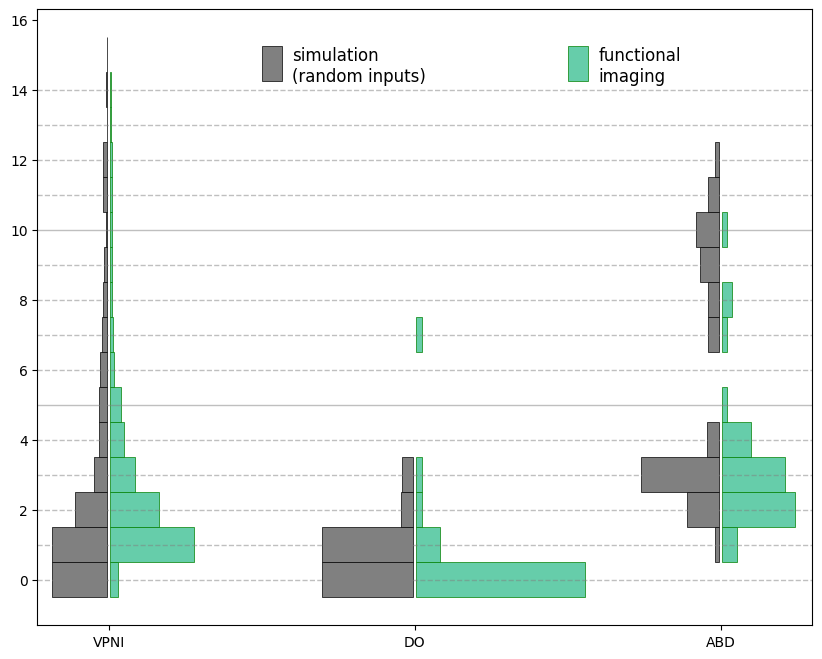

In [48]:
plt.figure(1,(10,8))

# model slopes from simulation
model_counts, functional_counts = compare_khist([lb_slopes_sim,np.reshape(fi_slopes,(Nexp,1))],[lb_cdf,fi_cdf],['simulation\n(random inputs)','functional\nimaging'],spacing=0.75,gap=0.007)
plt.xlim(0.4,4.2)

In [49]:
model_counts, functional_counts

([255, 34, 54], [605, 36, 43])

# Generate plots using new slopes

In [22]:
def new_slopes(df_path, do_path):
    # generate plots using new slopes
  df = pandas.read_csv(df_path,header=None)
  do_slopes = scipy.io.loadmat(do_path)
  do_slopes = do_slopes['slopes'][do_slopes['var2explain'][:,0] > 1,0]
  Nexp = len(df) + np.shape(do_slopes)[0]
  fi_slopes = np.zeros(Nexp)
  isVPNI = np.zeros(Nexp,dtype=bool)
  isABDM = np.zeros(Nexp,dtype=bool)
  isABDI = np.zeros(Nexp,dtype=bool)
  isDO = np.zeros(Nexp,dtype=bool)
  fi_slopes[:len(df)] = df.iloc[:,7].values
  fi_slopes[len(df):] = do_slopes
  #isVPNI[:len(df)] = (df.iloc[:,3].values == 0) & (df.iloc[:,4].values == 0) & (df.iloc[:,5].values == 0)
  isVPNI[:len(df)] = (df.iloc[:,5].values == 1)
  isABDM[:len(df)] = (df.iloc[:,3].values == 1)
  isABDI[:len(df)] = (df.iloc[:,4].values == 1)
  isDO[len(df):] = 1
  fi_cdf = pandas.DataFrame(np.array([isVPNI,isDO,isABDM,isABDI]),('integ','vest','abdm','abdi'))
  fi_slopes = fi_slopes * 2.574 / np.mean(fi_slopes[fi_cdf.loc['integ']])
  print(f'Functional cell count {np.sum(isVPNI),np.sum(isDO),np.sum(isABDM),np.sum(isABDI)}')
  return fi_slopes,fi_cdf, Nexp

Functional cell count (453, 37, 44, 18)
(102,)
2


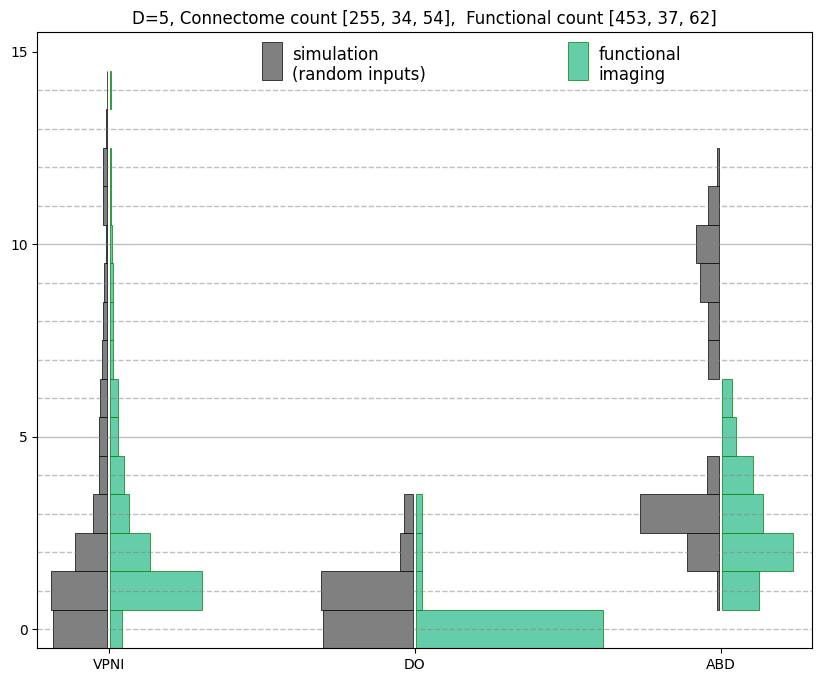

In [58]:
# generate plots using new slopes

fi_slopes_5, fi_cfd_5, Nexp_5 = new_slopes(df_path= '/content/drive/MyDrive/Colab Notebooks/Sood_code/New_slopes/slopesThresh_5_1152024.csv',
                                   do_path= '/content/drive/MyDrive/Colab Notebooks/Sood_code/New_slopes/fitCellsBasedOnLocationDO_5_1152024.mat',
                                          )

plt.figure(1,(10,8))
# model slopes from simulation D=5
model_counts, functional_counts = compare_khist([lb_slopes_sim,np.reshape(fi_slopes_5,(Nexp_5,1))],[lb_cdf,fi_cfd_5],['simulation\n(random inputs)','functional\nimaging'],spacing=0.75,gap=0.007)
plt.title(f"D=5, Connectome count {model_counts},  Functional count {functional_counts}")
plt.xlim(0.4,4.2)

plt.savefig('/content/drive/MyDrive/Zfish/ZfishData/Zfish_nn_final_edits/new_plots_11_6_2024/kvalues_compare_imaging_simulation_d5.pdf',dpi=500,transparent=True)



Functional cell count (452, 62, 57, 25)
(102,)
2


(0.4, 4.2)

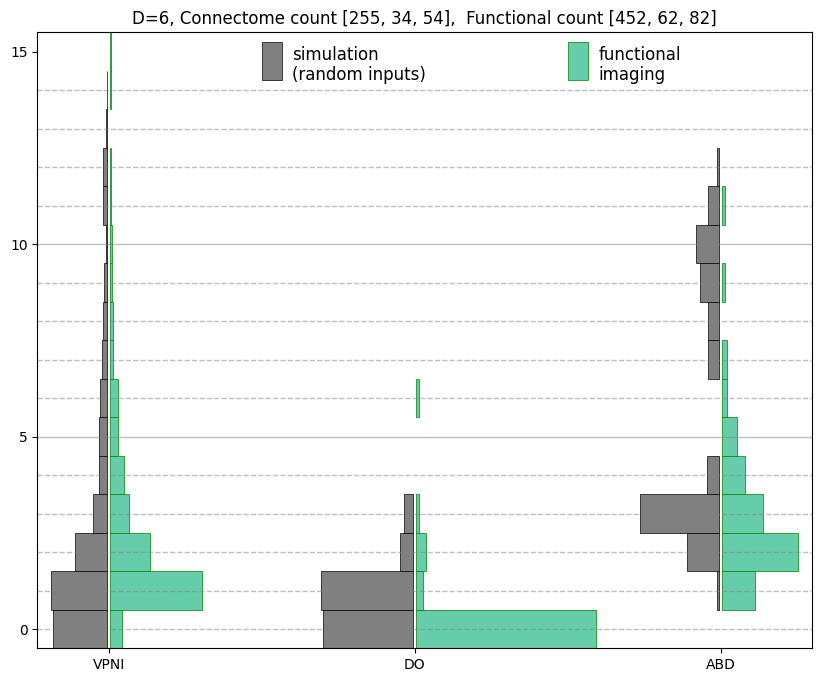

In [59]:
# generate plots using new slopes

fi_slopes_6, fi_cfd_6, Nexp_6 = new_slopes(df_path= '/content/drive/MyDrive/Colab Notebooks/Sood_code/New_slopes/slopesThresh_6_1152024.csv',
                                   do_path= '/content/drive/MyDrive/Colab Notebooks/Sood_code/New_slopes/fitCellsBasedOnLocationDO_6_1152024.mat',
                                          )

plt.figure(1,(10,8))
# model slopes from simulation D=5
model_counts, functional_counts = compare_khist([lb_slopes_sim,np.reshape(fi_slopes_6,(Nexp_6,1))],[lb_cdf,fi_cfd_6],['simulation\n(random inputs)','functional\nimaging'],spacing=0.75,gap=0.007)
plt.title(f"D=6, Connectome count {model_counts},  Functional count {functional_counts}")
plt.xlim(0.4,4.2)

plt.savefig('/content/drive/MyDrive/Zfish/ZfishData/Zfish_nn_final_edits/new_plots_11_6_2024/kvalues_compare_imaging_simulation_d6.pdf',dpi=500,transparent=True)

plt.xlim(0.4,4.2)

Functional cell count (452, 68, 78, 30)
(102,)
2


(0.4, 4.2)

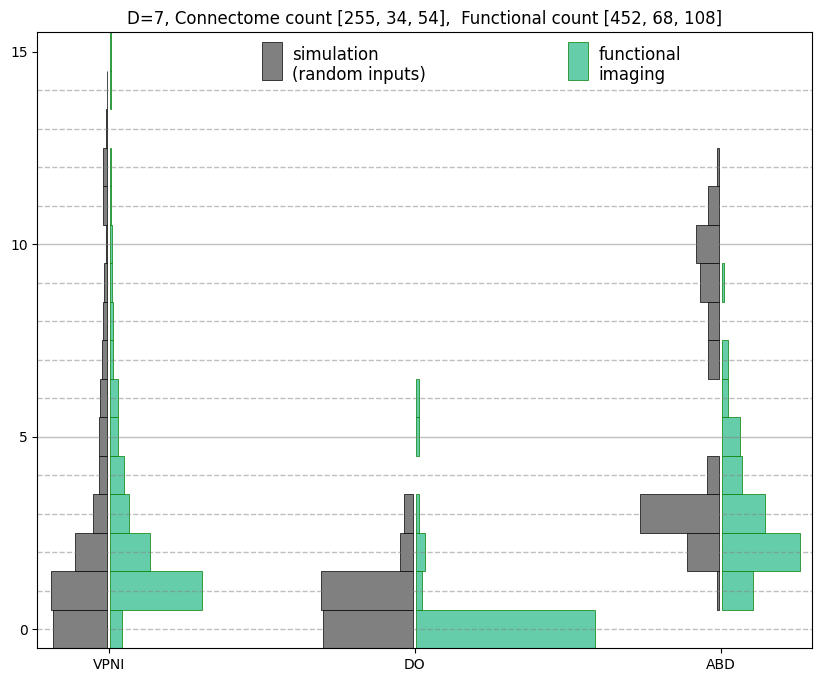

In [60]:
# generate plots using new slopes

fi_slopes_7, fi_cfd_7, Nexp_7 = new_slopes(df_path= '/content/drive/MyDrive/Colab Notebooks/Sood_code/New_slopes/slopesThresh_7_1152024.csv',
                                   do_path= '/content/drive/MyDrive/Colab Notebooks/Sood_code/New_slopes/fitCellsBasedOnLocationDO_7_1152024.mat',
                                          )

plt.figure(1,(10,8))
# model slopes from simulation D=5
model_counts, functional_counts = compare_khist([lb_slopes_sim,np.reshape(fi_slopes_7,(Nexp_7,1))],[lb_cdf,fi_cfd_7],['simulation\n(random inputs)','functional\nimaging'],spacing=0.75,gap=0.007)
plt.title(f"D=7, Connectome count {model_counts},  Functional count {functional_counts}")
plt.xlim(0.4,4.2)

plt.savefig('/content/drive/MyDrive/Zfish/ZfishData/Zfish_nn_final_edits/new_plots_11_6_2024/kvalues_compare_imaging_simulation_d7.pdf',dpi=500,transparent=True)

plt.xlim(0.4,4.2)

# Plots to compare with dynamics


In [ ]:
def simulate(W_in,ynew=0.99,tau=0.1,customInput=False,v_in=None,x=0):
    W = copy.deepcopy(W_in)
    #W[:,flag] = 0
    #W[flag,:] = 0
    y,v = sorted_eigs(W)
    #W[:,flag] = 0
    #W[flag,:] = 0
    #vL = np.linalg.pinv(v)
    n0 = np.sum(np.real(y) > 0)
    ymax = np.max(np.real(y))
    W = ynew*W/ymax
    #y,v2 = sorted_eigs(W)
    #print(y[0])
    #for i in range(3):
    #    print(np.dot(np.real(v[:,i]),np.real(v2[:,i])))
    N = np.shape(W)[0]
    #print(np.sum((abs(np.real(v[:,0])) > 5e-2) & (abs(np.real(v[:,1])) > 5e-2)))
    #print(v[538,0:3])
    if not customInput:
        #o = np.imag(y).argsort()
        #v_in = np.real(np.sum(v[:,x:x+1],axis=1)) + np.imag(np.sum(v[:,x:x+1],axis=1))
        v_in = 0.1*abs(np.random.randn(N))
        v_in += np.real(np.sum(v[:,0:1],axis=1)) + np.imag(np.sum(v[:,0:1],axis=1))
        v_in += 1*np.real(np.sum(v[:,1:3],axis=1)) + np.imag(np.sum(v[:,1:3],axis=1))
        #v_in[538] = 0
        #v_in += 20*(np.real(np.sum(v[:,1:3],axis=1)) + np.imag(np.sum(v[:,1:3],axis=1)))
        #theta = 2*math.pi*np.random.rand()
        #v_in += 4*(np.cos(theta)*np.real(v[:,o[0]]) + np.sin(theta)*np.imag(v[:,o[0]]))
        #v_in += np.real(v[:,1]) + 0.1*(np.cos(theta)*np.real(v[:,o[1]]) + np.sin(theta)*np.imag(v[:,o[1]]))
        #v_in = 10*np.real(vL[0,:]) - np.real(vL[1,:])
        #v_in = 0.05*abs(np.random.randn(N)) + np.real(v[:,0])
    v_in = v_in / np.linalg.norm(v_in)
    input_filter = 0.001*np.exp(-np.linspace(0,10,101))
    I = np.zeros(7000)
    I[995:1005] = 1e5
    I = np.convolve(I,input_filter)[0:7000]
    r = np.zeros((7000,N))
    dt = 0.001
    for i in range(1,7000):
        r[i,:] = r[i-1,:] + dt*(np.dot(W,r[i-1,:]) - r[i-1,:] + I[i-1]*v_in)/tau
        #r = r * (r > 0)
    return r[3333::333,:]

def fit_2exp_fixed_tau(stas,tau1=10,tau2=3):
    T,N = np.shape(stas)
    t = np.linspace(0,(T-1)*0.333333,T)
    A = np.zeros((T,2))
    A[:,0] = np.exp(-t/tau1)
    A[:,1] = np.exp(-t/tau2)
    coefs = np.zeros((N,2))
    lb = np.array([0,-999])
    ub = np.array([999,999])
    for i in range(N):
        b = stas[:,i]
        res = scipy.optimize.lsq_linear(A,b,method='trf',bounds=(lb,ub))
        coefs[i,:] = res.x[:]
    return coefs

def generate_stas_adj(stas_path):
  stas = scipy.io.loadmat(stas_path)
  abdm_mask = (stas['CellProps'][0][0][5][:,0] > 0)
  abdi_mask = (stas['CellProps'][0][0][6][:,0] > 0)
  vest_mask = (stas['CellProps'][0][0][7][:,0] > 0)
  int_mask = ((abdm_mask + abdi_mask + vest_mask) == 0)
  stas2 = np.zeros((12,635))
  baseline = np.zeros(635)
  for i in range(635):
      if stas['STA'][0][0][0][97,i] > stas['STA'][0][0][1][97,i]:
          stas2[:,i] = stas['STA'][0][0][0][97:109,i]
          baseline[i] = np.mean(stas['STA'][0][0][0][75:80,i])
      else:
          stas2[:,i] = stas['STA'][0][0][1][97:109,i]
          baseline[i] = np.mean(stas['STA'][0][0][1][75:80,i])
  stas_adj = stas2 - np.outer(np.ones(12),baseline) # 2-6 seconds post-saccade, adjusted for pre-saccade baseline
  return stas_adj

def generate_coefs(stas_adj, lb_rates, cell_filter):
  coefs_im = fit_2exp_fixed_tau(stas_adj,10,4)
  coefs_cn = fit_2exp_fixed_tau(lb_rates,10,4)
  sf1_im = 1.0/np.std(coefs_im[:,0])
  sf1_cn = 1.0/np.std(coefs_cn[cell_filter,0])
  sf2_im = 1.0#/np.std(coefs_im[:,1])
  sf2_cn = 1.0#/np.std(coefs_cn[:,1])
  coefs_im = coefs_im*sf1_im
  coefs_cn = coefs_cn*sf1_cn
  #coefs_exp = np.zeros((609,2))
  #coefs_exp[:,0] = v[:,0]*np.dot(lb_rates[0,:],vL[0,:])
  #coefs_exp[:,1] = v[:,1]*np.dot(lb_rates[0,:],vL[1,:])
  #sf1_exp = 1.0/np.std(coefs_exp[cell_filter,0])
  #coefs_exp = coefs_exp*sf1_exp

  # variance explained
  u_im,s_im,v_im = np.linalg.svd(stas_adj)
  u_cn,s_cn,v_cn = np.linalg.svd(lb_rates[:,cell_filter])
  cv_im = s_im[:10]**2/np.sum(s_im**2)
  cv_cn = s_cn[:10]**2/np.sum(s_cn**2)
  for i in range(1,10):
      cv_im[i] += cv_im[i-1]
      cv_cn[i] += cv_cn[i-1]

  return coefs_im,coefs_cn,cv_im,cv_cn,sf1_im,sf1_cn,sf2_im,sf2_cn

In [ ]:
my_v_in = 0.1*abs(np.random.randn(N))
y,v1 = sorted_eigs(lb_Wnorm)
my_v_in1 = 1*my_v_in + np.real(np.sum(v1[:,0:1],axis=1))# + np.imag(np.sum(v1[:,0:1],axis=1))
my_v_in1 += 1*np.real(np.sum(v1[:,1:3],axis=1))# + np.imag(np.sum(v1[:,1:2],axis=1))
lb_rates = simulate(lb_Wnorm,ynew=0.9,tau=1.0,customInput=True,v_in=my_v_in1)
#my_v_in1 = 1*my_v_in + np.real(np.sum(v1[:,0:1],axis=1))# + np.imag(np.sum(v1[:,0:1],axis=1))
#my_v_in1 += 0.5*np.real(np.sum(v1[:,1:2],axis=1)) + 1.5*np.real(np.sum(v1[:,2:3],axis=1))# + np.imag(np.sum(v1[:,1:2],axis=1))
#lb_rates2 = simulate(lb_Wnorm,ynew=0.9,tau=1.0,customInput=True,v_in=my_v_in1)
#lb_rates = np.concatenate([lb_rates,lb_rates2],axis=0)
y_scaled = 0.95 * y / np.real(y[0])
print(1.0/(1.0 - y_scaled[0]),1.0/(1.0 - y_scaled[1]))
Wprime = copy.deepcopy(lb_Wnorm)
Wprime[:,flag] = 0
Wprime[flag,:] = 0
y,v2 = sorted_eigs(Wprime)
for i in range(3):
    if np.dot(np.real(v1[:,i]),np.real(v2[:,i])) < 0:
        v2[:,i] = -v2[:,i]
my_v_in2 = my_v_in + np.real(np.sum(v2[:,0:1],axis=1)) + np.imag(np.sum(v2[:,0:1],axis=1))
my_v_in2 += 1*np.real(np.sum(v2[:,1:3],axis=1)) + np.imag(np.sum(v2[:,1:3],axis=1))
lb_rates2 = simulate(Wprime,ynew=0.9,tau=1.0,customInput=True,v_in=my_v_in2)

(19.999999999999982+0j) (2.247334795208839+0j)


In [ ]:
cell_filter = (cellIDs == 'ABD_m') | (cellIDs == 'ABD_i') | (cellIDs == '_Int_') # | (lbid ==1)

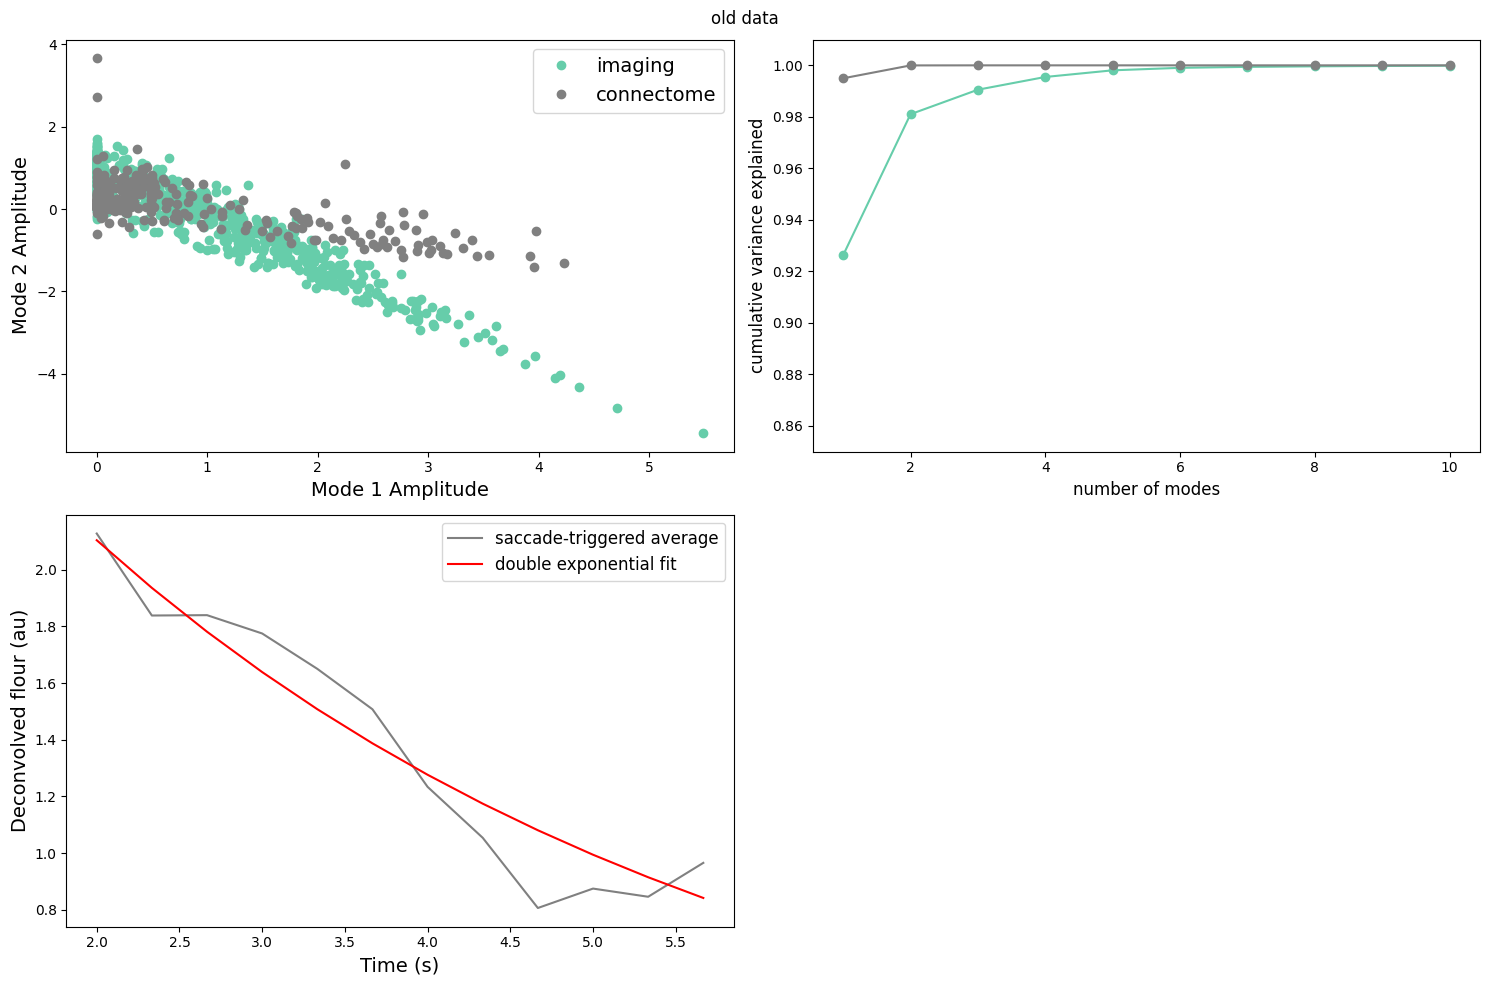

In [ ]:
stas_adj = generate_stas_adj('/content/drive/MyDrive/Colab Notebooks/Sood_code/data/STA_EMCA.mat')
coefs_im,coefs_cn,cv_im,cv_cn,sf1_im,sf1_cn,sf2_im,sf2_cn = generate_coefs(stas_adj,lb_rates,cell_filter)

plt.figure(1,(15,10))
plt.subplot(2,2,1)
plt.plot(coefs_im[:,0],coefs_im[:,1],'o',label='imaging',color='mediumaquamarine')
plt.plot(coefs_cn[cell_filter,0],coefs_cn[cell_filter,1],'o',label='connectome',color='gray')
#plt.plot(coefs_cn[flag,0],coefs_cn[flag,1],'o',label='least central',color='orange')
plt.xlabel('Mode 1 Amplitude',fontsize=14)
plt.ylabel('Mode 2 Amplitude',fontsize=14)
plt.legend(fontsize=14)
#plt.savefig('plots/double_exponential_fit.pdf',dpi=300,transparent=True)

plt.subplot(2,2,2)
plt.plot(np.linspace(1,10,10),cv_im,'o-',color='mediumaquamarine',label='imaging')
plt.plot(np.linspace(1,10,10),cv_cn,'o-',color='gray',label='connectome')
plt.xlabel('number of modes',fontsize=12)
plt.ylabel('cumulative variance explained',fontsize=12)
plt.ylim(0.85,1.01)
#plt.savefig('plots/cumulative_variance_explained.pdf',dpi=300,transparent=True)

plt.subplot(2,2,3)
T = np.shape(stas_adj)[0]
t = np.linspace(2,2+(T-1)*0.333333,T)
nindex = 5
plt.plot(t,stas_adj[:,nindex],label='saccade-triggered average',color='gray')
plt.plot(t,coefs_im[nindex,0]*np.exp(-(t-2)/10)/sf1_im + coefs_im[nindex,1]*np.exp(-(t-2)/4)/sf1_im,label='double exponential fit',color='red')
plt.xlabel('Time (s)',fontsize=14)
plt.ylabel('Deconvolved flour (au)',fontsize=14)
plt.legend(fontsize=12)
#plt.savefig('plots/connectome_paper/plots_requested0708/double_exponential_fit_example_trace.pdf',dpi=300,transparent=True)

plt.suptitle('old data')
plt.tight_layout()

# Dynamics for new data

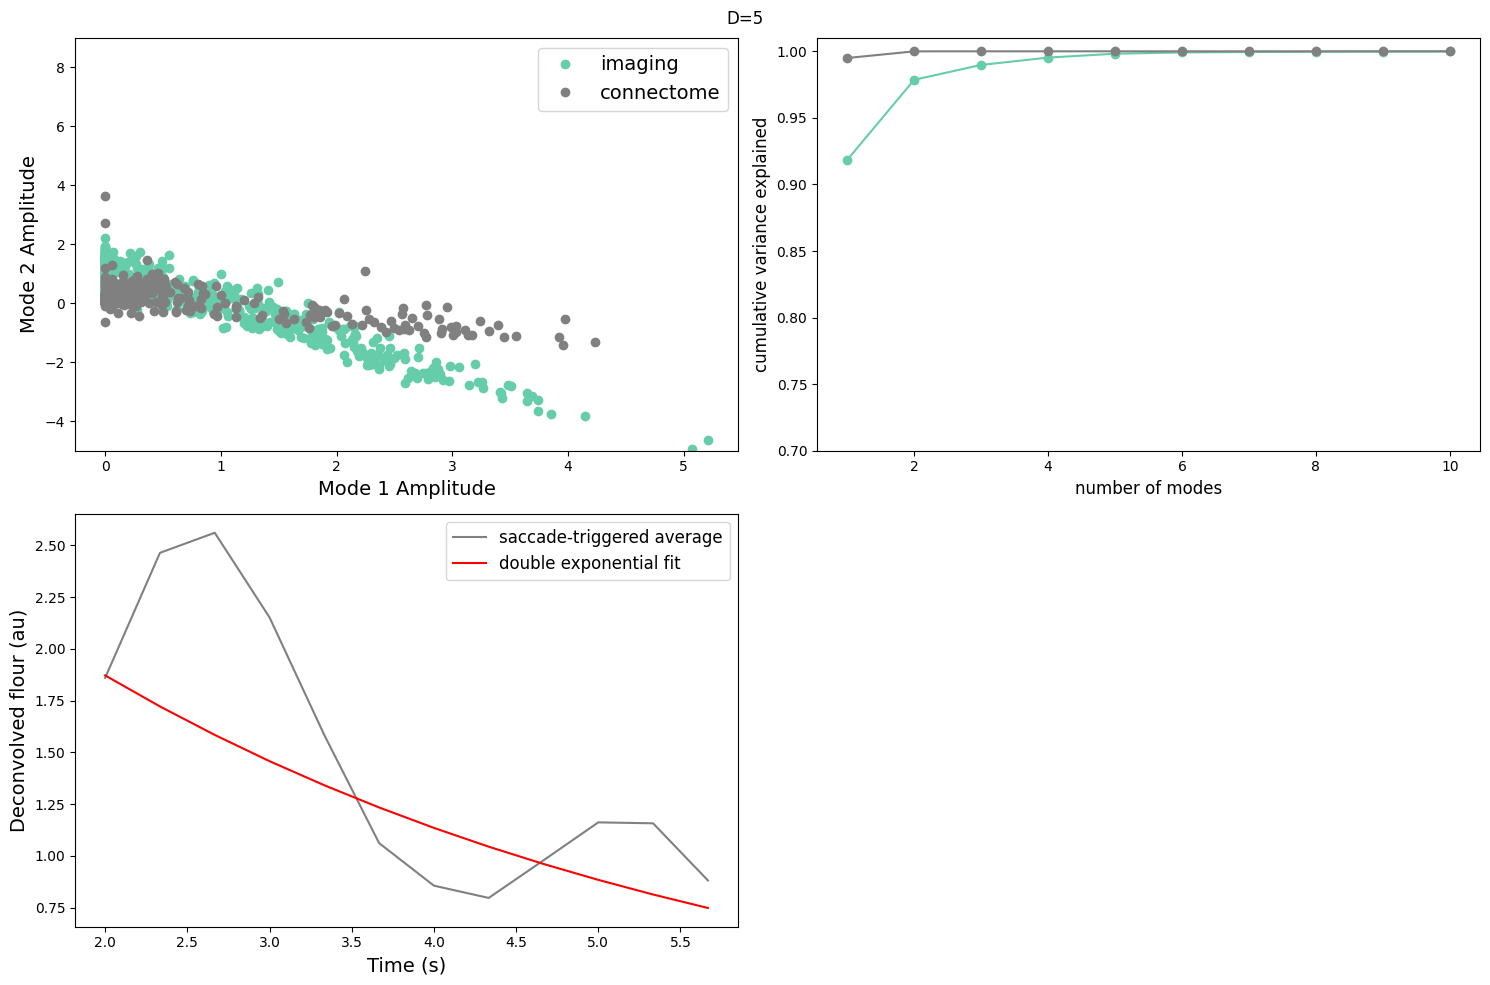

In [ ]:
stas_adj_5 = generate_stas_adj('/content/drive/MyDrive/Colab Notebooks/Sood_code/New_slopes/STA_EMCA_5_1152024.mat')
coefs_im_5,coefs_cn,cv_im_5,cv_cn,sf1_im_5,sf1_cn,sf2_im_5,sf2_cn = generate_coefs(stas_adj_5,lb_rates,cell_filter)

plt.figure(1,(15,10))
plt.subplot(2,2,1)
plt.plot(coefs_im_5[:,0],coefs_im_5[:,1],'o',label='imaging',color='mediumaquamarine')
plt.plot(coefs_cn[cell_filter,0],coefs_cn[cell_filter,1],'o',label='connectome',color='gray')
#plt.plot(coefs_cn[flag,0],coefs_cn[flag,1],'o',label='least central',color='orange')
plt.xlabel('Mode 1 Amplitude',fontsize=14)
plt.ylabel('Mode 2 Amplitude',fontsize=14)
plt.ylim(-5,9)
plt.legend(fontsize=14)
#plt.savefig('plots/double_exponential_fit.pdf',dpi=300,transparent=True)

plt.subplot(2,2,2)
plt.plot(np.linspace(1,10,10),cv_im_5,'o-',color='mediumaquamarine',label='imaging')
plt.plot(np.linspace(1,10,10),cv_cn,'o-',color='gray',label='connectome')
plt.xlabel('number of modes',fontsize=12)
plt.ylabel('cumulative variance explained',fontsize=12)
plt.ylim(0.7,1.01)
#plt.savefig('plots/cumulative_variance_explained.pdf',dpi=300,transparent=True)

plt.subplot(2,2,3)
T = np.shape(stas_adj_5)[0]
t = np.linspace(2,2+(T-1)*0.333333,T)
nindex = 5
plt.plot(t,stas_adj_5[:,nindex],label='saccade-triggered average',color='gray')
plt.plot(t,coefs_im_5[nindex,0]*np.exp(-(t-2)/10)/sf1_im_5 + coefs_im[nindex,1]*np.exp(-(t-2)/4)/sf1_im_5,label='double exponential fit',color='red')
plt.xlabel('Time (s)',fontsize=14)
plt.ylabel('Deconvolved flour (au)',fontsize=14)
plt.legend(fontsize=12)

plt.suptitle('D=5')
plt.tight_layout()

plt.savefig('plots/connectome_paper/plots_requested0708/double_exponential_fit_example_trace.pdf',dpi=300,transparent=True)


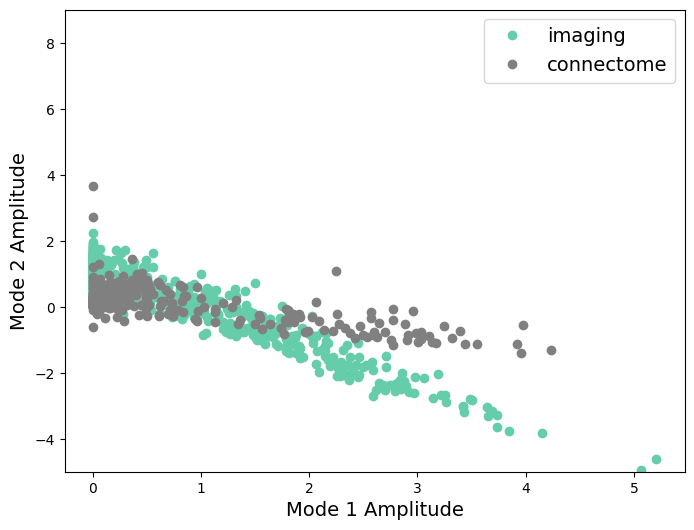

In [ ]:
plt.figure(1,(8,6))
plt.plot(coefs_im_5[:,0],coefs_im_5[:,1],'o',label='imaging',color='mediumaquamarine')
plt.plot(coefs_cn[cell_filter,0],coefs_cn[cell_filter,1],'o',label='connectome',color='gray')
#plt.plot(coefs_cn[flag,0],coefs_cn[flag,1],'o',label='least central',color='orange')
plt.xlabel('Mode 1 Amplitude',fontsize=14)
plt.ylabel('Mode 2 Amplitude',fontsize=14)
plt.ylim(-5,9)
plt.legend(fontsize=14)
plt.savefig('/content/drive/MyDrive/Colab Notebooks/Sood_code/plots/double_exponential_fit_d5.pdf',dpi=300,transparent=True)

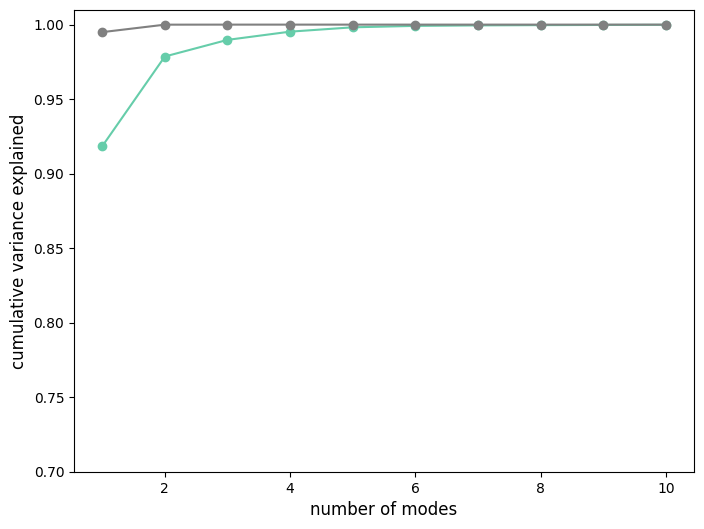

In [ ]:
plt.figure(1,(8,6))
plt.plot(np.linspace(1,10,10),cv_im_5,'o-',color='mediumaquamarine',label='imaging')
plt.plot(np.linspace(1,10,10),cv_cn,'o-',color='gray',label='connectome')
plt.xlabel('number of modes',fontsize=12)
plt.ylabel('cumulative variance explained',fontsize=12)
plt.ylim(0.7,1.01)
plt.savefig('/content/drive/MyDrive/Zfish/ZfishData/Zfish_nn_final_edits/new_plots_11_6_2024/cumulative_variance_explained_d5.pdf',dpi=300,transparent=True)

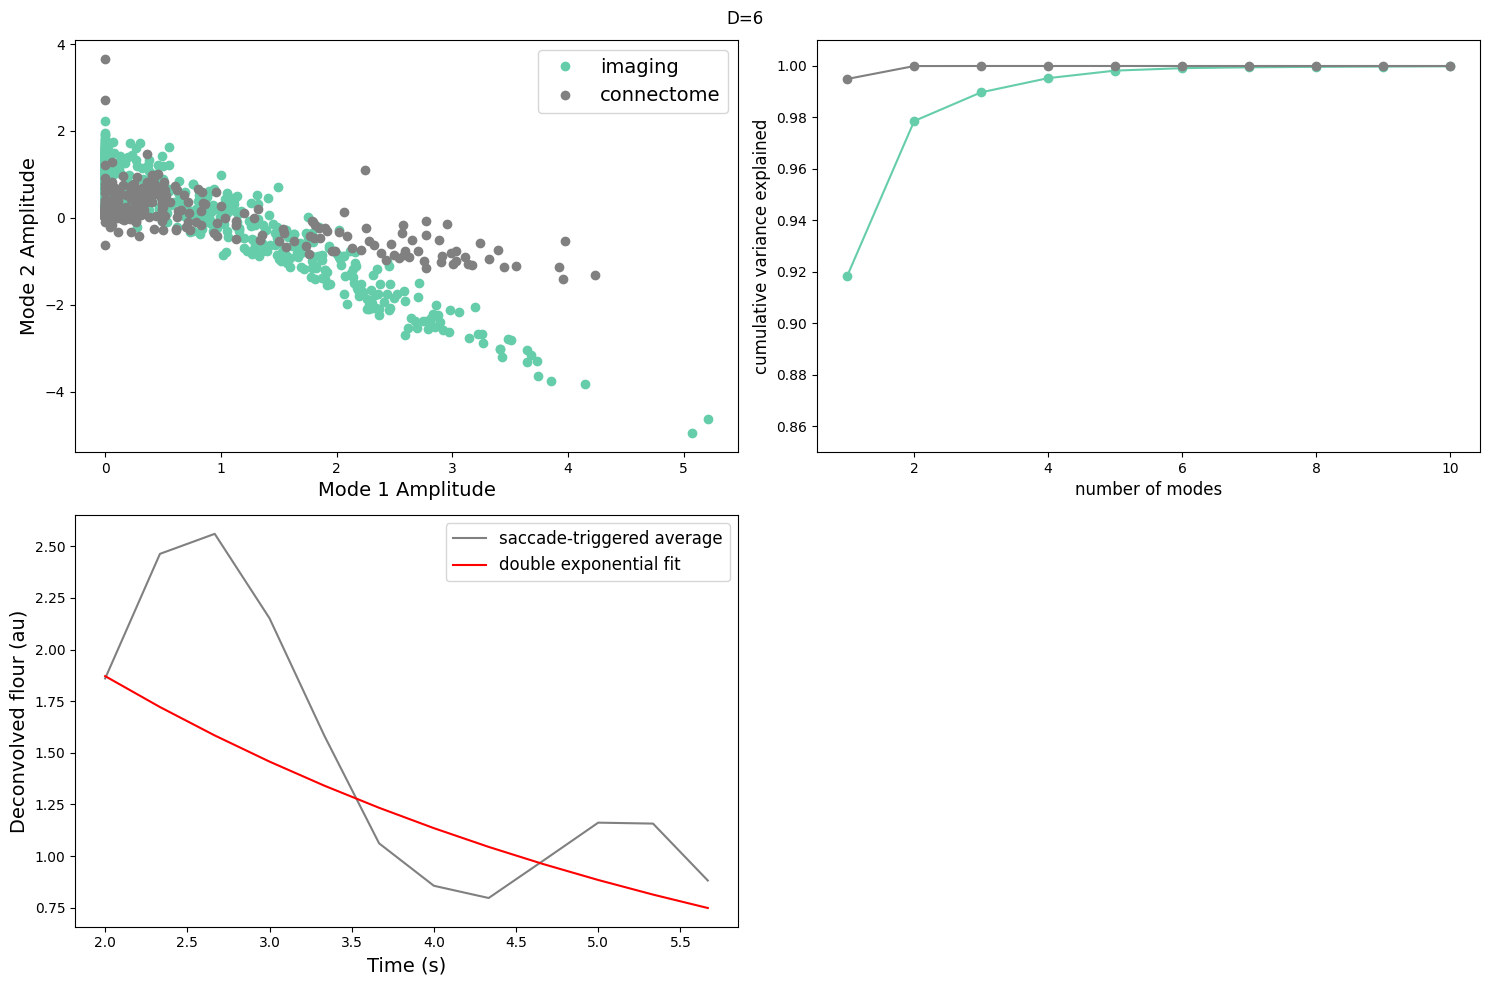

In [ ]:
stas_adj_6 = generate_stas_adj('/content/drive/MyDrive/Colab Notebooks/Sood_code/New_slopes/STA_EMCA_6_1152024.mat')
coefs_im_6,coefs_cn,cv_im_6,cv_cn,sf1_im_6,sf1_cn,sf2_im_6,sf2_cn = generate_coefs(stas_adj_6,lb_rates,cell_filter)

plt.figure(1,(15,10))
plt.subplot(2,2,1)
plt.plot(coefs_im_6[:,0],coefs_im_6[:,1],'o',label='imaging',color='mediumaquamarine')
plt.plot(coefs_cn[cell_filter,0],coefs_cn[cell_filter,1],'o',label='connectome',color='gray')
#plt.plot(coefs_cn[flag,0],coefs_cn[flag,1],'o',label='least central',color='orange')
plt.xlabel('Mode 1 Amplitude',fontsize=14)
plt.ylabel('Mode 2 Amplitude',fontsize=14)
plt.legend(fontsize=14)
#plt.savefig('plots/double_exponential_fit.pdf',dpi=300,transparent=True)

plt.subplot(2,2,2)
plt.plot(np.linspace(1,10,10),cv_im_6,'o-',color='mediumaquamarine',label='imaging')
plt.plot(np.linspace(1,10,10),cv_cn,'o-',color='gray',label='connectome')
plt.xlabel('number of modes',fontsize=12)
plt.ylabel('cumulative variance explained',fontsize=12)
plt.ylim(0.85,1.01)
#plt.savefig('plots/cumulative_variance_explained.pdf',dpi=300,transparent=True)

plt.subplot(2,2,3)
T = np.shape(stas_adj_6)[0]
t = np.linspace(2,2+(T-1)*0.333333,T)
nindex = 5
plt.plot(t,stas_adj_6[:,nindex],label='saccade-triggered average',color='gray')
plt.plot(t,coefs_im_6[nindex,0]*np.exp(-(t-2)/10)/sf1_im_6 + coefs_im[nindex,1]*np.exp(-(t-2)/4)/sf1_im_6,label='double exponential fit',color='red')
plt.xlabel('Time (s)',fontsize=14)
plt.ylabel('Deconvolved flour (au)',fontsize=14)
plt.legend(fontsize=12)
#plt.savefig('plots/connectome_paper/plots_requested0708/double_exponential_fit_example_trace.pdf',dpi=300,transparent=True)

plt.suptitle('D=6')
plt.tight_layout()

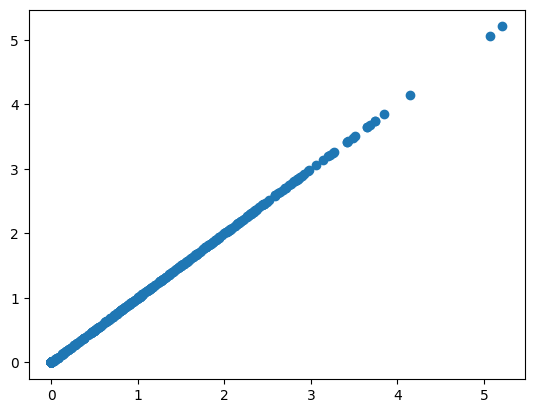

In [ ]:
plt.scatter(coefs_im_5[:,0],coefs_im_6[:,0],label='D=5')
# plt.scatter(coefs_im_6[:,0],coefs_im_6[:,1],label='D=6')

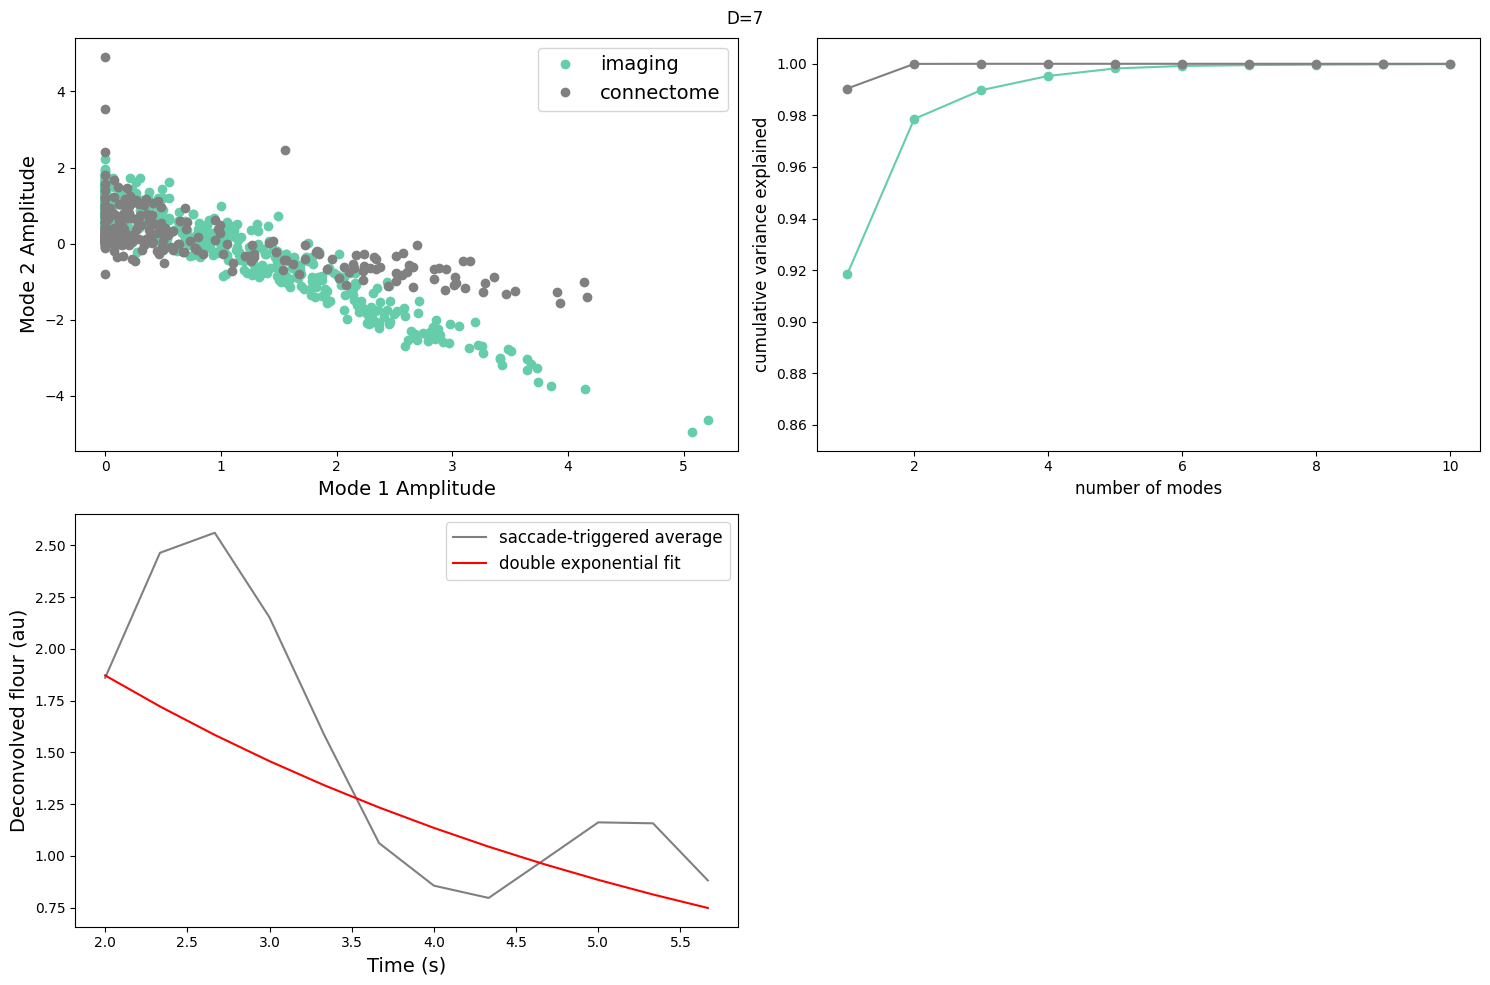

In [ ]:
stas_adj_7 = generate_stas_adj('/content/drive/MyDrive/Colab Notebooks/Sood_code/New_slopes/STA_EMCA_7_1152024.mat')
coefs_im_7,coefs_cn,cv_im_7,cv_cn,sf1_im_7,sf1_cn,sf2_im_7,sf2_cn = generate_coefs(stas_adj_7,lb_rates,cell_filter)

plt.figure(1,(15,10))
plt.subplot(2,2,1)
plt.plot(coefs_im_7[:,0],coefs_im_7[:,1],'o',label='imaging',color='mediumaquamarine')
plt.plot(coefs_cn[cell_filter,0],coefs_cn[cell_filter,1],'o',label='connectome',color='gray')
#plt.plot(coefs_cn[flag,0],coefs_cn[flag,1],'o',label='least central',color='orange')
plt.xlabel('Mode 1 Amplitude',fontsize=14)
plt.ylabel('Mode 2 Amplitude',fontsize=14)
plt.legend(fontsize=14)
#plt.savefig('plots/double_exponential_fit.pdf',dpi=300,transparent=True)

plt.subplot(2,2,2)
plt.plot(np.linspace(1,10,10),cv_im_7,'o-',color='mediumaquamarine',label='imaging')
plt.plot(np.linspace(1,10,10),cv_cn,'o-',color='gray',label='connectome')
plt.xlabel('number of modes',fontsize=12)
plt.ylabel('cumulative variance explained',fontsize=12)
plt.ylim(0.85,1.01)
#plt.savefig('plots/cumulative_variance_explained.pdf',dpi=300,transparent=True)

plt.subplot(2,2,3)
T = np.shape(stas_adj_7)[0]
t = np.linspace(2,2+(T-1)*0.333333,T)
nindex = 5
plt.plot(t,stas_adj_7[:,nindex],label='saccade-triggered average',color='gray')
plt.plot(t,coefs_im_7[nindex,0]*np.exp(-(t-2)/10)/sf1_im_7 + coefs_im[nindex,1]*np.exp(-(t-2)/4)/sf1_im_7,label='double exponential fit',color='red')
plt.xlabel('Time (s)',fontsize=14)
plt.ylabel('Deconvolved flour (au)',fontsize=14)
plt.legend(fontsize=12)
#plt.savefig('plots/connectome_paper/plots_requested0708/double_exponential_fit_example_trace.pdf',dpi=300,transparent=True)

plt.suptitle('D=7')
plt.tight_layout()